In [1]:
import pandas as pd
import numpy  as np
import tqdm
import lightgbm as lgb
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_val_predict
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
warnings.simplefilter('ignore')
%matplotlib inline

In [2]:
data = pd.read_csv('task2.txt', sep='\t', header=None, names=[f'x{i}' for i in range(10)] + ['y'])

#### оставим часть данных, чтобы проверить, что модель не переобучилась при отборе, генерации, трансформации признаков

In [3]:
train, test = train_test_split(data, random_state=2020, shuffle=True, train_size=0.8)

# Разведочный анализ

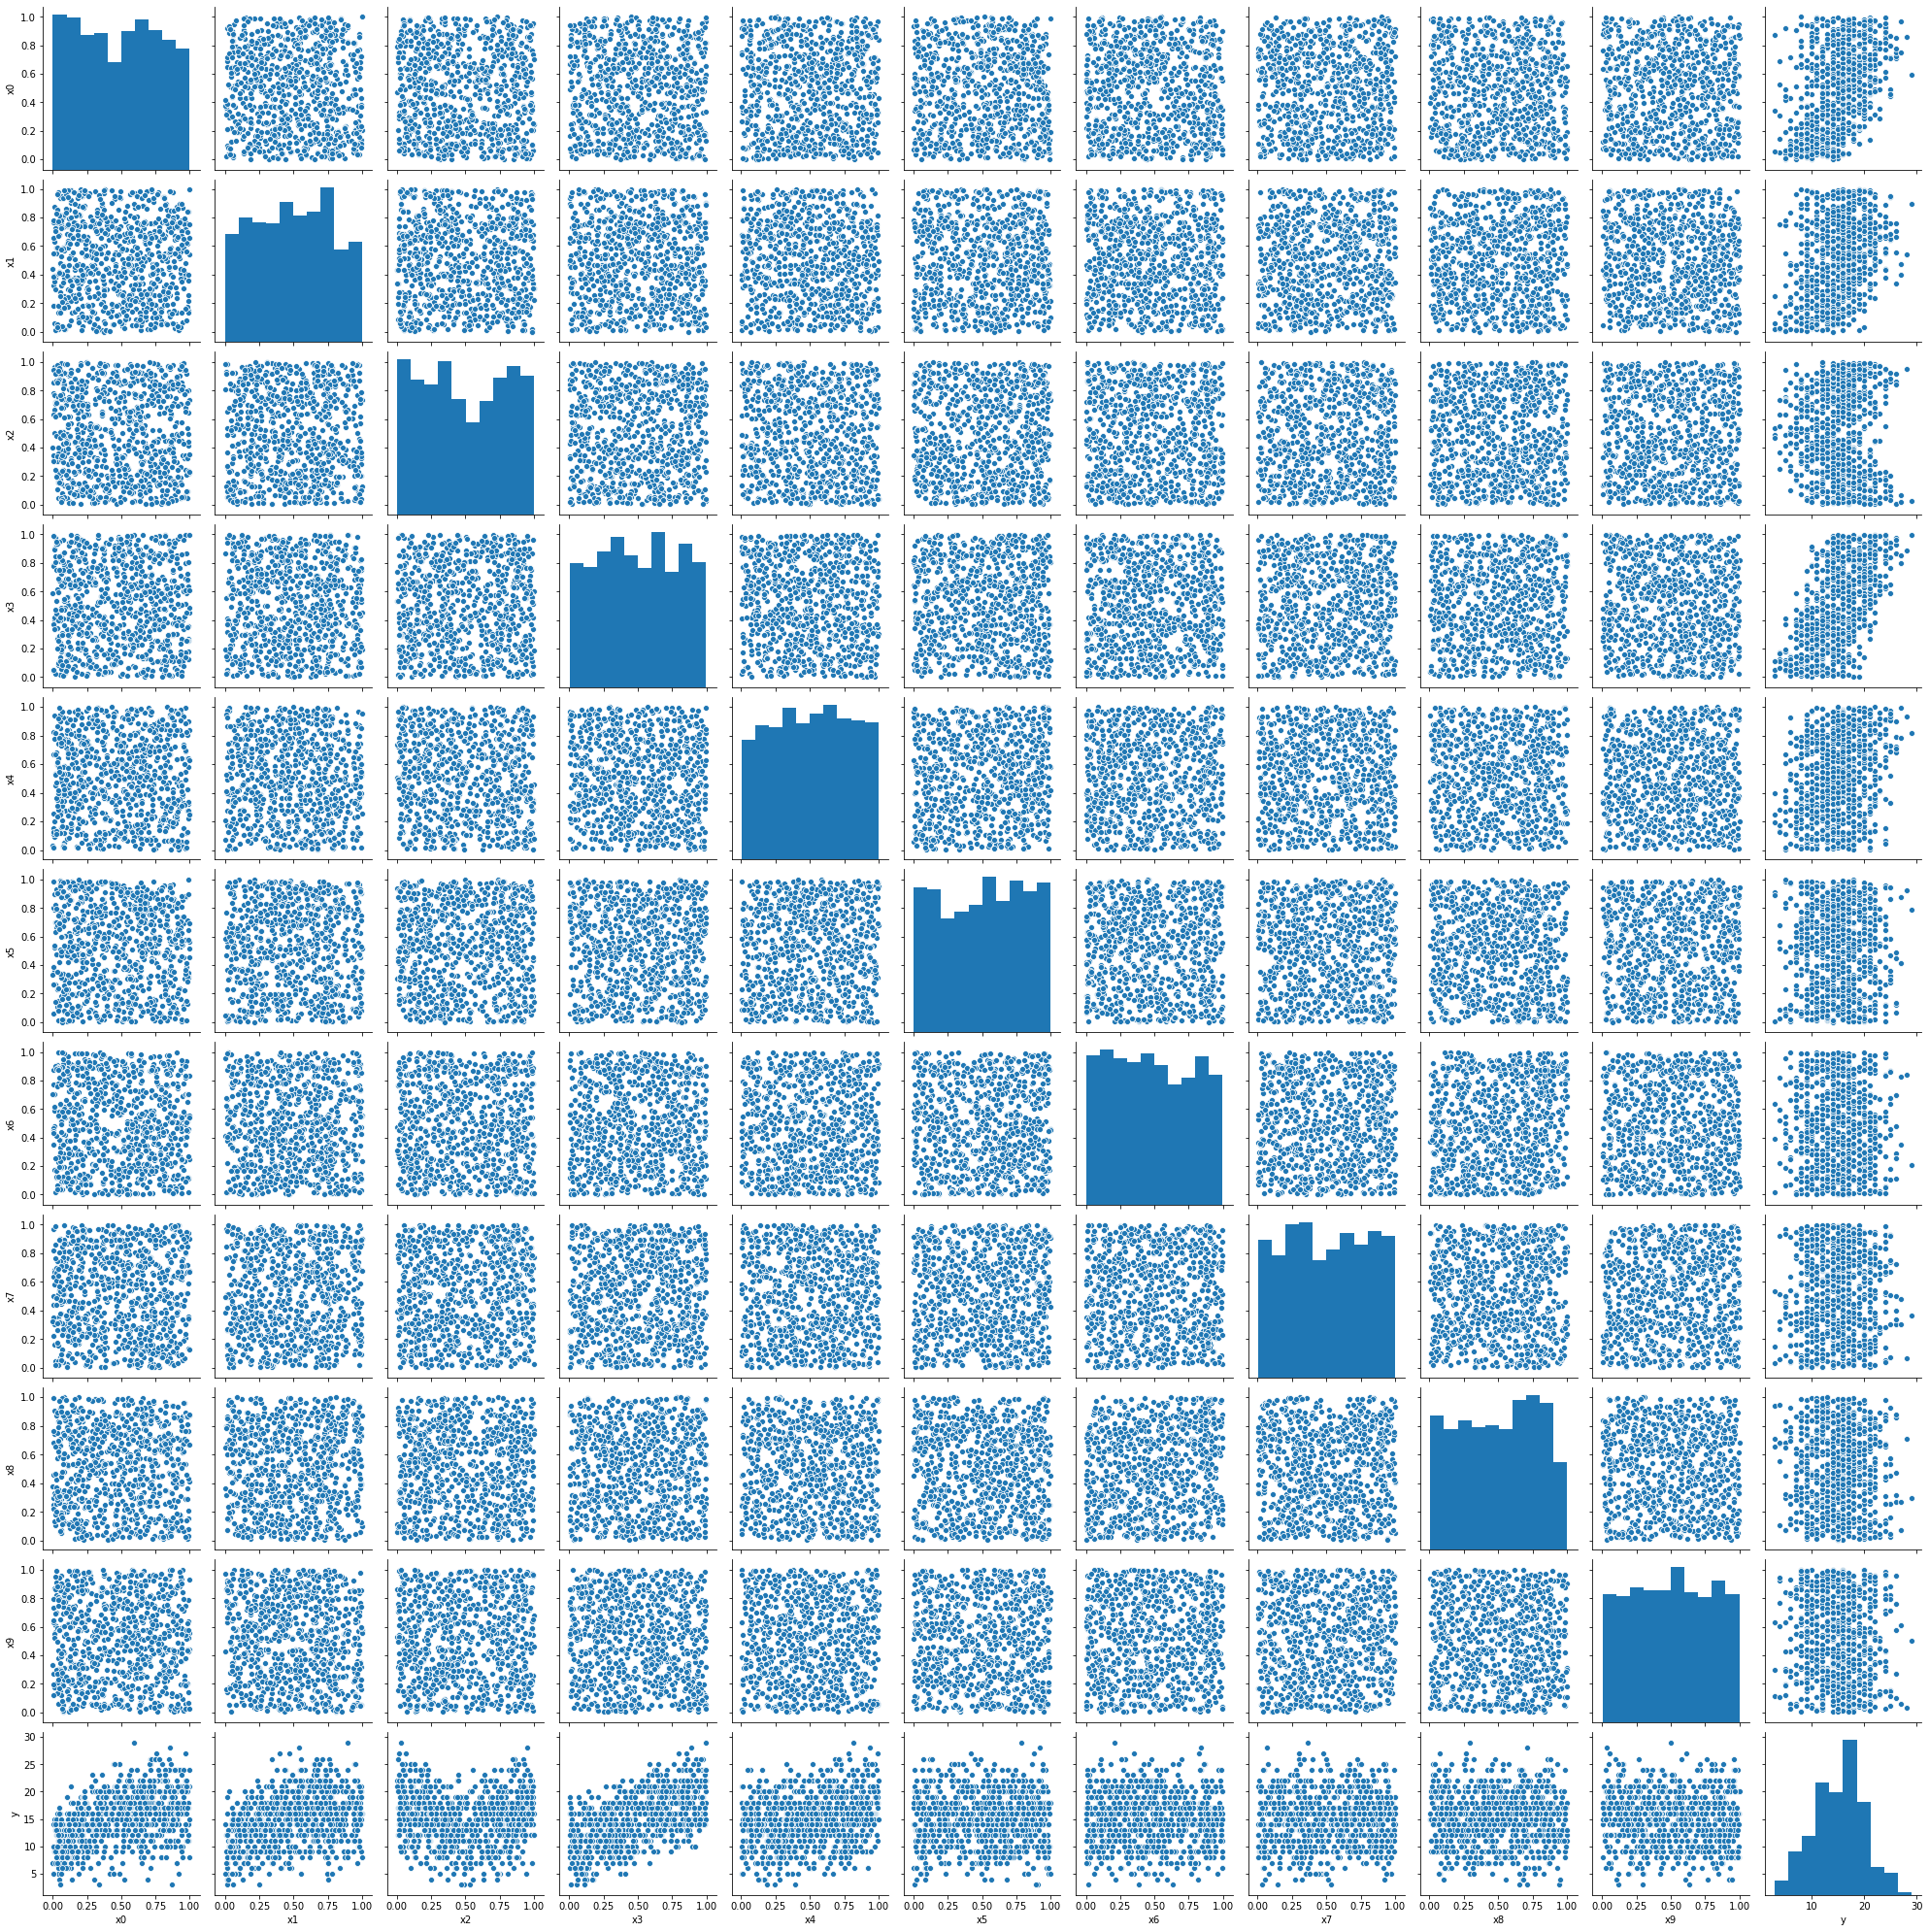

In [4]:
sns.pairplot(train);

#### похоже что признаки равномерно распределены от 0 до 1
видны линейные зависимости таргета от x0, x1, x3, x4;

так же видна квадратичная зависимость от x2;

возможно есть какие то  дополнительные полиномиальные зависимости

##### скорее всего признаки независимы друг от друга, т.к. на scatter plot не видно паттернов
для сравнения привожу независимые случайные величины, scatter plot очень похож

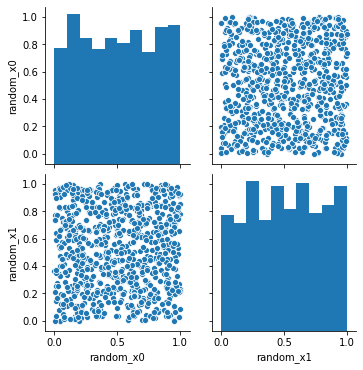

In [5]:
df_random = pd.DataFrame()
df_random['random_x0'] = np.random.uniform(0, 1, size=800)
df_random['random_x1'] = np.random.uniform(0, 1, size=800)
sns.pairplot(df_random);

#### посмотрим, что говорит матрица корреляций

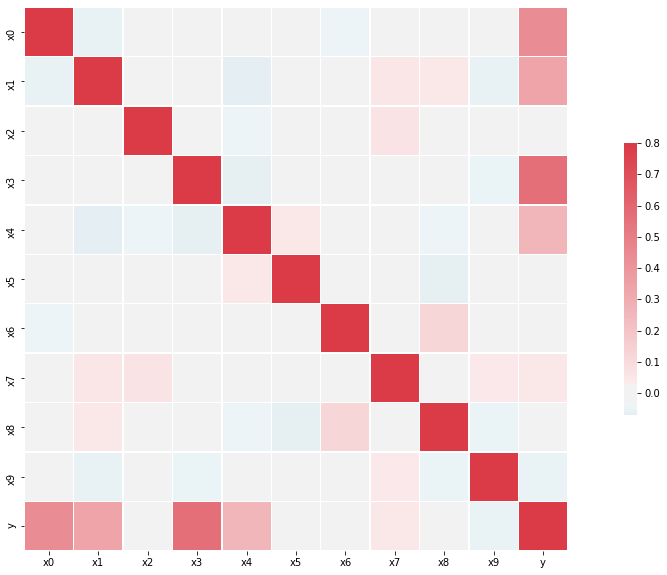

In [6]:
plt.figure(figsize=(20,10))
sns.heatmap(train.corr(), vmax=.8, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5},
           cmap=sns.diverging_palette(220, 10, as_cmap=True));

матрица корреляций показывает только линейные связи, но и по скаттер плоту мы видим что фичи не зависят друг от друга

С таргетом же немножко другая ситуация, x5-x9 имеют нулевую корреляцию с таргетом, и это видно на скаттерплотах, а вот x2 хоть и имеет нулевую корреляцию, по скаттер плоту видна нелинейная связь

####  для таргета не видно зависимостей от x5-x9, посмотрим внимательнее

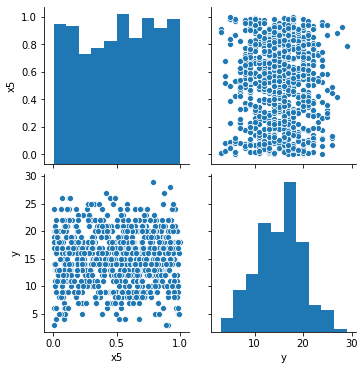

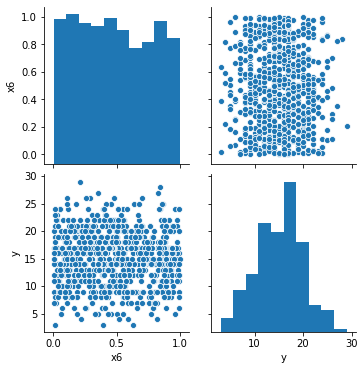

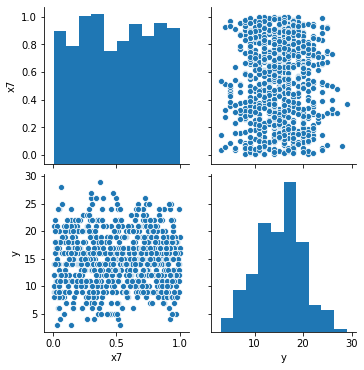

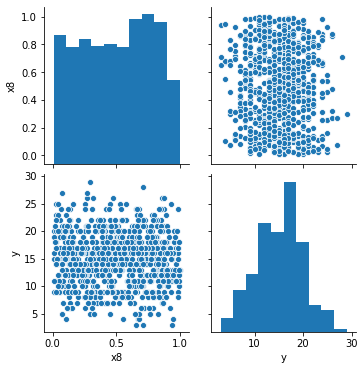

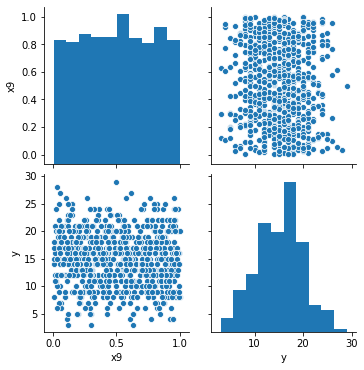

In [7]:
for i in ['x5', 'x6', 'x7', 'x8', 'x9']:
    sns.pairplot(train[[i, 'y']]);

###### распределение таргета похоже на нормальное, поэтому сравним скаттер плоты, со случаем независимых нормальной и равномерной СВ

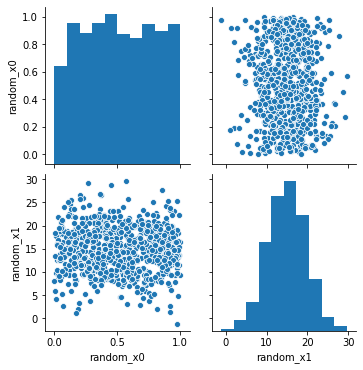

In [8]:
df_random = pd.DataFrame()
df_random['random_x0'] = np.random.uniform(0, 1, size=800)
df_random['random_x1'] = np.random.normal(train['y'].mean(), train['y'].std(), size=800)
sns.pairplot(df_random);

#### скаттер плоты очень похожи, на те что для x5-x9, 

### попробуем построить нелинейную модель, для отлавливания сложных зависимостей тартега от x5-x9

In [9]:
X_train, X_val = train_test_split(train, shuffle=True, random_state=42, train_size=0.8)
rf_regressor = RandomForestRegressor().fit(X_train[['x5', 'x6', 'x7', 'x8', 'x9']], X_train['y'])
prediction = rf_regressor.predict(X_val[['x5', 'x6', 'x7', 'x8', 'x9']])
(mean_squared_error(X_val['y'], prediction),
 np.mean([mean_squared_error(X_val['y'], np.random.permutation(prediction)) for i in range(1000)]))

(22.86712375, 22.515449999999998)

#### видим, что и random forest не смог найти никаких зависимостей, так как случайное перемешивания предсказаний никак не повлияло на метрику качества

# построение полиномиальной регрессии

In [10]:
good_cols = ['x0', 'x1', 'x2', 'x3', 'x4'] # значимые признаки

### степень полинома - гиперпараметр, будем подбирать по кроссвалидации

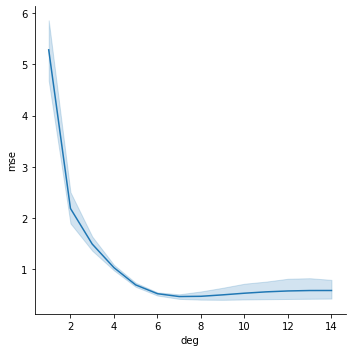

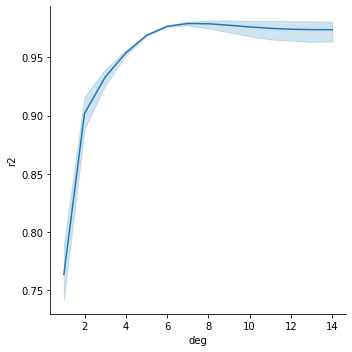

In [11]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
polynomial_df = []
for tr_ix, te_ix in tqdm.tqdm_notebook(kf.split(train), total=5):
    X_train = train.iloc[tr_ix]
    X_val = train.iloc[te_ix]
    fold_mse = []
    fold_r2 = []
    for i in range(1, 15):
        pf_train = PolynomialFeatures(i, include_bias=False).fit_transform(X_train[good_cols])
        pf_val = PolynomialFeatures(i, include_bias=False).fit_transform(X_val[good_cols])
        lr = Ridge().fit(pf_train, X_train['y'])
        fold_mse.append(mean_squared_error(X_val['y'], lr.predict(pf_val)))
        fold_r2.append(r2_score(X_val['y'], lr.predict(pf_val)))
    fold_df = pd.DataFrame()
    fold_df['mse'] = fold_mse
    fold_df['r2'] = fold_r2
    fold_df['deg'] = np.arange(1, 15)
    polynomial_df.append(fold_df)
polynomial_df = pd.concat(polynomial_df)

sns.relplot(x="deg", y="mse", 
            kind="line", data=polynomial_df)
sns.relplot(x="deg", y="r2", 
            kind="line", data=polynomial_df);

#### по графику видно, что полином 6й степени оптимален для задачи
при самых лучших скорах, у полинома 6й степени еще и разброс ошибки минимален между фолдами

#### взглянем подробнее на предсказания полинома 6й степени

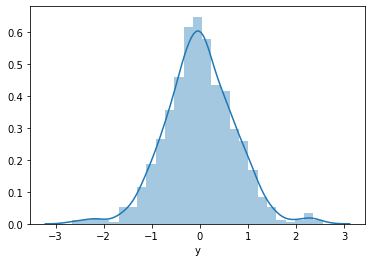

In [12]:
pf_train = PolynomialFeatures(6, include_bias=False).fit_transform(train[good_cols])

oof_predicts = cross_val_predict(Ridge(), pf_train, train['y'],
                                 cv=KFold(n_splits=5, shuffle=True, random_state=42))

sns.distplot(oof_predicts-train['y']);

#### остатки похожи на нормально-распределенные

# попробуем улучшить модель с помощью бустинга (забустим полиномиальную регрессию деревьями)

In [13]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'mse',
    'metric': 'l2',
    'learning_rate': 0.01,
    'lambda_l1':1,
    'lambda_l2':1,
    'min_data_in_leaf':10
}


kf = KFold(n_splits=5, shuffle=True, random_state=42)
pf_transform = PolynomialFeatures(6, include_bias=False)

oof_predicts_gbm = np.zeros_like(oof_predicts)
polynomial_df = []
for tr_ix, te_ix in tqdm.tqdm_notebook(kf.split(train), total=5):
    X_train = train.iloc[tr_ix]
    X_val = train.iloc[te_ix]
    
    
    train_init_scores = cross_val_predict(Ridge(),
                      pf_transform.fit_transform(X_train[good_cols]),
                      X_train['y'],
                      cv=KFold(n_splits=5, shuffle=True, random_state=42))
    test_init_scores = Ridge().fit(pf_transform.fit_transform(X_train[good_cols]),
                X_train['y']).predict(pf_transform.fit_transform(X_val[good_cols]))
    
    X_train_lgb = lgb.Dataset(X_train[good_cols], X_train['y'], init_score=train_init_scores)
    X_val_lgb = lgb.Dataset(X_val[good_cols], X_val['y'], init_score=test_init_scores)

    gbm = lgb.train(params,
                X_train_lgb,
                num_boost_round=1_000,
#                 valid_sets=[X_train_lgb,X_val_lgb],
#                 early_stopping_rounds=100,
#                 verbose_eval=100
                   )
    oof_predicts_gbm[te_ix] = gbm.predict(X_val[good_cols]) + test_init_scores

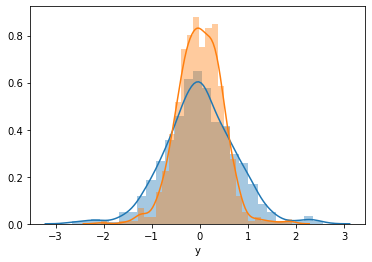

In [14]:
sns.distplot(oof_predicts-train['y']);
sns.distplot(oof_predicts_gbm-train['y']);

In [15]:
mean_squared_error(train['y'],oof_predicts), r2_score(train['y'],oof_predicts)

(0.5260116162218125, 0.9765407977637625)

In [16]:
mean_squared_error(train['y'],oof_predicts_gbm), r2_score(train['y'],oof_predicts_gbm)

(0.21205171691879443, 0.9905428626320646)

#### видно что бустинг значительно сузил ошибку, и повысил r2 с 0.976 до 0.99, mse уменьшилось с 0.52 до 0.21

###### для сравнения что будет если просто запустить бустинг (без бустинга полиномиальной регрессии)

In [17]:
oof_predicts_gbm_no_lr = np.zeros_like(oof_predicts)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
polynomial_df = []
for tr_ix, te_ix in tqdm.tqdm_notebook(kf.split(train), total=5):
    
    X_train = train.iloc[tr_ix]
    X_val = train.iloc[te_ix]

    X_train_lgb = lgb.Dataset(X_train[good_cols], X_train['y'])
    X_val_lgb = lgb.Dataset(X_val[good_cols], X_val['y'])
    
    gbm = lgb.train(params,
                X_train_lgb,
                num_boost_round=50_000,
                valid_sets=[X_train_lgb,X_val_lgb],
                early_stopping_rounds=50,
                verbose_eval=False)
    oof_predicts_gbm_no_lr[te_ix] = gbm.predict(X_val[good_cols])

In [18]:
mean_squared_error(train['y'],oof_predicts_gbm_no_lr), r2_score(train['y'],oof_predicts_gbm_no_lr)

(1.278258978062493, 0.942991875175606)

# теперь вспомним что в самом начале мы отложили выборку, протестируем пайплайн на ней

In [19]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'mse',
    'metric': 'l2',
    'learning_rate': 0.01,
    'lambda_l1':1,
    'lambda_l2':1,
    'min_data_in_leaf':10
}


pf_transform = PolynomialFeatures(6, include_bias=False)

train_init_scores = cross_val_predict(Ridge(),
                  pf_transform.fit_transform(train[good_cols]),
                  train['y'],
                  cv=KFold(n_splits=5, shuffle=True, random_state=42))


test_init_scores = Ridge().fit(pf_transform.fit_transform(train[good_cols]),
                train['y']).predict(pf_transform.fit_transform(test[good_cols]))
    
    
X_train_lgb = lgb.Dataset(train[good_cols], train['y'], init_score=train_init_scores)

gbm = lgb.train(params,
                X_train_lgb,
                num_boost_round=1_000)

test_gbm_lr_predict = gbm.predict(test[good_cols])+test_init_scores

In [20]:
mean_squared_error(test['y'], test_gbm_lr_predict), r2_score(test['y'], test_gbm_lr_predict)

(0.1924944404432534, 0.9919857763012248)

# Выводы
получена среднеквадратичная ошибка 0.19 и r2 0.99 для тестовой выборки

значимые признаки - x0-x4

функция хорошо апроксимируется полиномом 6-й степени, но при этом все еще остаются возможности для улучшения, например как было сделано с помощью градиентного бустинга на деревьях

конечная модель почти идеально восстановила функцию, очевидно что данные сгенерированы с помощью какой то детерминированной функции, при желании можно поисследовать поверхность, которую порождает построенная модель, возможно получиться написать более точную формулу для изначальной поверхности